In [237]:
import numpy as np
import torch
import math
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torch.optim as optim
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error



# 1 Non-linear regression

In [219]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## 1.1 Data acquisition

We keep the Dataset wrapper from Ex. 02.

In [220]:
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y ).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index], self.y[index]
  
  def __len__(self) -> int:
    return self.len

In Exercise 02, we manually split our data into training and test set. Since this is a standard procedure, it is helpful to write a function doing that for us. Feel free to modify it!

In [221]:
def split_data(x_full: np.ndarray,
               y_full: np.ndarray,
               train_fraction: float):
    """Generates three pytorch Datasets (full, train, test) given a set of features and labels."""

    # define fraction of data used for training
    assert x_full.shape[0] == y_full.shape[0]
    
    n_samples = y_full.shape[0]

    n_train = int(train_fraction * n_samples)

    # get indices for training and test set
    ids = np.arange(n_samples)
    np.random.shuffle(ids)
    ids_train, ids_test  = np.split(ids, [n_train])

    all_data = Data(x_full, y_full)
    train_data = Data(x_full[ids_train], y_full[ids_train])
    test_data = Data(x_full[ids_test], y_full[ids_test])

    return all_data, train_data, test_data

## 1.2 Neural network

In [222]:
class MLP(nn.Module):
    def __init__(self, n_units: list, activation= nn.ReLU()):
        """
            Simple multi-layer perceptron (MLP).

            Parameters:
            -----------
            n_units : List of integers specifying the dimensions of input and output and the hidden layers.
            activation: Activation function used for non-linearity. 


            Example:
            -----------

            dim_hidden = 100
            dim_in = 2
            dim_out = 5

            # MLP with input dimension 2, output dimension 5, and 4 hidden layers of dimension 100
            model = MLP([dim_in,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_out],activation=nn.ReLU()).to(DEVICE)

        """
        super().__init__()

        # Get input and output dimensions
        dims_in = n_units[:-1]
        dims_out = n_units[1:]

        layers = []

        # Add linear layers (and activation function after all layers except the final one)
        for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            layers.append(torch.nn.Linear(dim_in, dim_out))
            
            if i < len(n_units) - 2:
                layers.append(activation)
        

        self._layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
            MLP forward pass

        """
        return self._layers(x)
    
    def count_parameters(self): 
        """
            Counts the number of trainable parameters.

        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In Exercise 02, we saw how a basic training loop in pytorch looks like. Since we will need this exact training procedure a number of times, it is useful to define a function for it. Feel free to modify it!

In [223]:
    # """
    #     Basic training loop for a pytorch model.

    #     Parameters:
    #     -----------
    #     model : pytorch model.
    #     train_loader : pytorch Dataloader containing the training data.
    #     optimizer: Optimizer for gradient descent. 
    #     criterion: Loss function. 
        

    #     Example usage:
    #     -----------

    #     model = (...) # a pytorch model
    #     criterion = (...) # a pytorch loss
    #     optimizer = (...) # a pytorch optimizer
    #     trainloader = (...) # a pytorch DataLoader containing the training data

    #     n_epochs = 10000
    #     for epoch in range(1, n_epochs):
    #         epoch_loss = train(model, trainloader,optimizer, criterion)
            

    # """
        
    # # Set model to training mode
    # model.train()
    # epoch_loss = 0
    # n_batches = len(train_loader)

    # # Loop over each batch from the training set
    # for (data, target) in train_loader:
    
    #     # Copy data to GPU if needed
    #     data = data.to(DEVICE)
    #     target = target.to(DEVICE)

    #     # set optimizer to zero grad to remove previous gradients
    #     optimizer.zero_grad() 

    #     # Pass data through the network
    #     output = model(data)

    #     # Calculate loss
    #     loss = criterion(output, target)

    #     # get gradients
    #     loss.backward()
        
    #     # gradient descent
    #     optimizer.step()
        
    #     epoch_loss += loss.data.item()

    # return epoch_loss / n_batches


In [224]:
# x = np.linspace(-1, 2, 1000).reshape(-1, 1)

In [225]:
def f(x):
    return x + 1.5*math.pow(x,2) + 0.5*math.pow(x,3)  - 0.7*math.pow(x,4) + math.sin(5*x) + math.cos(10*x)

In [252]:
# x = np.linspace(-1, 2, 100).reshape(-1, 1)
# x
#
# split_data(x, y)

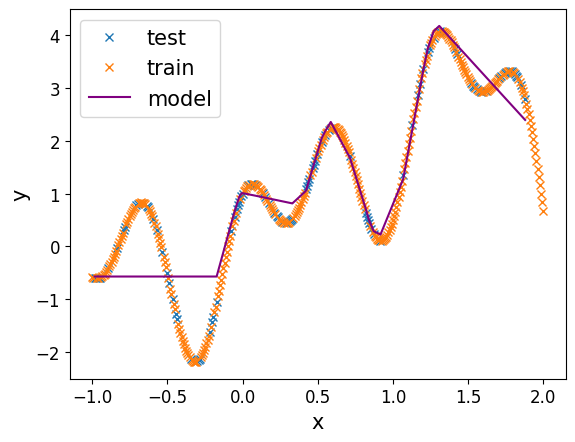

In [228]:
def plot_model(train_data, test_data, model):
    x_test_sorted, _ = torch.sort(test_data.x, dim=0)
    # print(x_test_sorted)
    with torch.no_grad():
        y_pred_test_sorted = model(x_test_sorted)
        
    plt.plot(test_data.x,test_data.y, 'x', label = 'test')
    plt.plot(train_data.x,train_data.y, 'x', label = 'train')
    plt.plot(x_test_sorted, y_pred_test_sorted,  label = 'model',c="purple")
    plt.legend(fontsize=15)
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


In [254]:
# x_test_sorted

In [292]:


batch_size = 16
learning_rate = .002
num_data_points = 100

dimensions = [
    [1, 100, 1],
    [1, 100, 100, 1],
    [1, 100, 100, 100, 100, 100, 1],
    [1, 5, 1],
    [1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1],
    [1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1], 
    [1, 3, 10, 50, 10, 3, 1],
    [1, 5, 20, 100, 100, 100, 20, 50, 1],
    [1, 100, 100, 100, 100, 100, 100, 100, 1],
]

In [293]:


x = np.linspace(-1, 2, num_data_points).reshape(-1, 1)
y = np.array([f(xi) for xi in x])

all_data, train_data, test_data = split_data(x, y, .75)
trainloader = DataLoader(train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
testloader = DataLoader(test_data, 
                         batch_size=batch_size, 
                         shuffle=True)
# print(len(all_data))
# print(len(train_data))
# print(len(test_data))

# plot_model(train_data, test_data, model)

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_72239/4180293399.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return x + 1.5*math.pow(x,2) + 0.5*math.pow(x,3)  - 0.7*math.pow(x,4) + math.sin(5*x) + math.cos(10*x)


In [231]:
print(model.parameters())

<generator object Module.parameters at 0x12e3d5d20>


In [232]:
 # Set model to training mode
def train(model, optimizer):
    model.train()
    epoch_loss = 0
    n_batches = len(trainloader)
    
    # Loop over each batch from the training set
    for (data, target) in trainloader:
    
        # Copy data to GPU if needed
        data = data.to(DEVICE)
        target = target.to(DEVICE)
    
        # set optimizer to zero grad to remove previous gradients
        optimizer.zero_grad() 
    
        # Pass data through the network
        output = model(data)
    
        # Calculate loss
        loss = criterion(output, target)
    
        # get gradients
        loss.backward()
        
        # gradient descent
        optimizer.step()
        
        epoch_loss += loss.data.item()

    return epoch_loss / n_batches


In [294]:

models = []
for dims in dimensions:
    models.append(MLP(dims).to(DEVICE))

optimizers = []
criterion = nn.MSELoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)


epochs = 100
learning_rate = 5e-3

all_losses = []
for model in models:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    i = 0
    losses = []
    while (i < epochs):
        loss = train(model, optimizer)
        losses.append(loss)
        # print(loss)
        i += 1
    all_losses.append(losses)


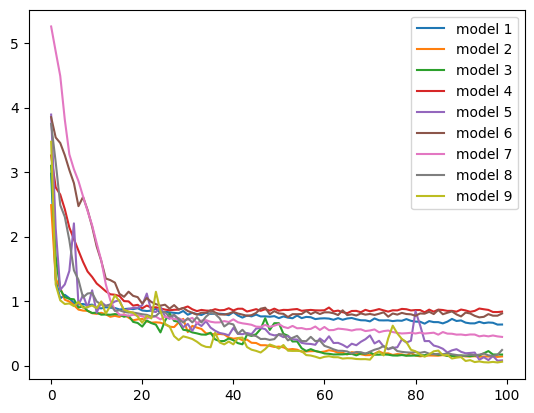

In [295]:
i = 1
for losses in all_losses:
    plt.plot(losses, label=f"model {i}")
    i += 1
plt.legend()
plt.show()

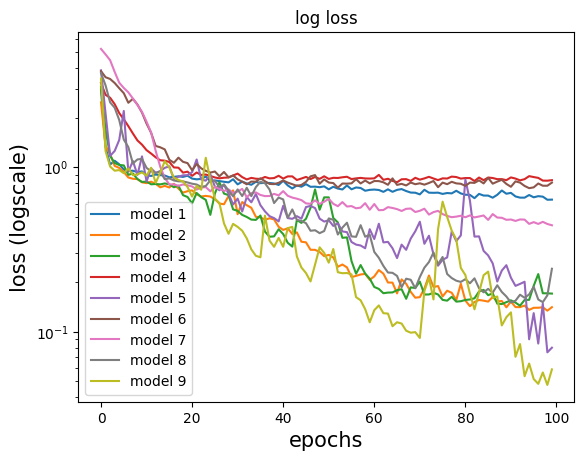

In [296]:
# plt.yscale("log")
# plt.plot(losses)
# plt.title(f"log loss")
# plt.xlabel('epochs', fontsize=15)
# plt.ylabel('loss (logscale)', fontsize=15)
# plt.show()

i = 1
for losses in all_losses:
    plt.plot(losses, label=f"model {i}")
    i += 1
plt.title(f"log loss")
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss (logscale)', fontsize=15)
plt.yscale("log")
plt.legend()
plt.show()

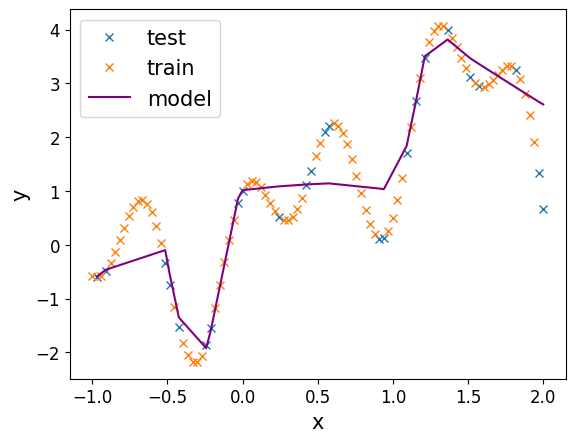

In [297]:
plot_model(train_data, test_data, models[2])

In [299]:
all_mse_test = []
all_mse_train = []
all_num_nodes = []
labels = []
with torch.no_grad():
    i = 0 
    while (i < len(models)):
        all_num_nodes.append(sum(dimensions[i]))
        y_pred_train = models[i](train_data.x)
        y_pred_test = models[i](test_data.x)
        
        all_mse_test.append(mean_squared_error(test_data.y,y_pred_test))
        all_mse_train.append(mean_squared_error(train_data.y,y_pred_train))

        i += 1
        labels.append(f"Model {i}")

            

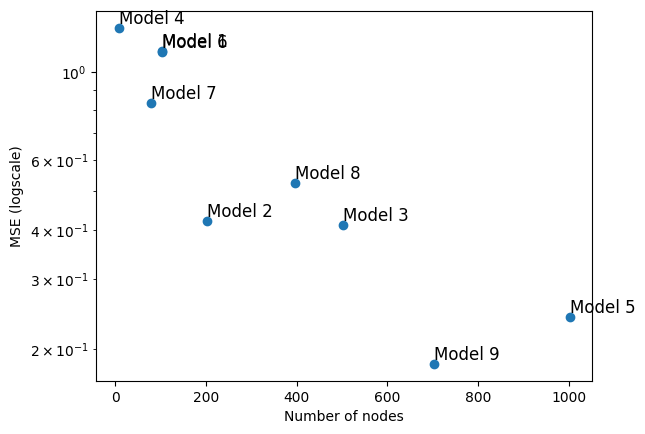

In [300]:
plt.scatter(all_num_nodes, all_mse_test)

for i, label in enumerate(labels):
    plt.text(all_num_nodes[i], all_mse_test[i], label, fontsize=12, ha='left', va='bottom')

plt.xlabel("Number of nodes")
plt.ylabel("MSE (logscale)")
plt.yscale("log")

plt.show()